In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
import cv2

In [105]:
if re.match(".*/notebooks$", os.getcwd()):
    os.chdir("../")  # change directory to root directory
annotation_path = "./data/annotations.csv"
raw_data_path = "./data/raw/"

# Data analýza
K dispozícii máme 22126 obrázkov a príslušných anotácii. Každá anotácia podáva informácie o názve snímku, na ktorom je pes zachytený, veľkosti, počtu kanálov snímku, názve plemena na obrázku. Stĺpce xmin xmax ymin ymax uvádzajú súradnice ohraničujúce psa na obrázku.

In [106]:
df = pd.read_csv(annotation_path, index_col="id")
df

,filename,width,height,depth,name,xmin,xmax,ymin,ymax
id,,,,,,,,,
0,n02085620_10074,333,500,3,chihuahua,25,276,10,498
1,n02085620_10131,395,495,3,chihuahua,49,393,9,493
2,n02085620_10621,500,298,3,chihuahua,142,335,43,250
3,n02085620_1073,345,500,3,chihuahua,0,312,27,498
4,n02085620_10976,322,484,3,chihuahua,90,242,104,452
...,...,...,...,...,...,...,...,...,...
22121,n02116738_9818,500,333,3,african_hunting_dog,48,499,0,332
22122,n02116738_9829,202,300,3,african_hunting_dog,0,170,39,299
22123,n02116738_9844,600,400,3,african_hunting_dog,199,473,136,348


In [107]:
df["name"].value_counts()


afghan_hound          287
maltese_dog           264
irish_wolfhound       263
leonberg              256
scottish_deerhound    246
                     ... 
rottweiler            153
brabancon_griffon     153
groenendael           152
pekinese              152
redbone               151
Name: name, Length: 120, dtype: int64

Celkovo je na obrázkoch zachytených 22126 psov 120 rôynzch plemien.

In [108]:
width_mean = (df["width"]).mean()
height_mean = (df["height"]).mean()

x_mean = (df["xmax"] - df["xmin"]).mean()
y_mean = (df["ymax"] - df["ymin"]).mean()

x_min = df["xmin"].min()
x_min_count = (df["xmin"].values == x_min).sum()

x_max = df["xmax"].max()
x_max_count = (df["xmax"].values == x_max).sum()

y_min = df["ymin"].min()
y_min_count = (df["ymin"].values == y_min).sum()

y_max = df["ymax"].max()
y_max_count = (df["ymax"].values == y_max).sum()

dog_on_full_image_count = df[(df['xmin'] == x_min) & (df['ymin'] == y_min) & (df['xmax'] == x_max) & (df['ymax'] == y_max)]['xmin'].count()

print("Priemerná veľkosť pôvodného obrázka:", int(width_mean), "x", int(height_mean), "pixelov.")
print("Priemerný výrez obrázka, na ktorom je pes zachytený:", int(x_mean), "x", int(y_mean), "pixelov.\n")

print("Minimalne a maximalne vyrezy psov na obrázkoch a ich počty.")
print("min x pozicia: " + str(x_min) + "     pocet: (" + str(x_min_count) + ")")
print("max x pozicia: " + str(x_max) + "  pocet: (" + str(x_max_count) + ")")
print("min y pozicia: " + str(y_min) + "     pocet: (" + str(y_min_count) + ")")
print("max y pozicia: " + str(y_max) + "  pocet: (" + str(y_max_count) + ")")
print("\nPočet obrázkov so psom na celom obrázku: ", xy_min_count)

Priemerná veľkosť pôvodného obrázka: 444 x 384 pixelov.
Priemerný výrez obrázka, na ktorom je pes zachytený: 281 x 290 pixelov.

Minimalne a maximalne vyrezy psov na obrázkoch a ich počty.
min x pozicia: 0     pocet: (2278)
max x pozicia: 2735  pocet: (1)
min y pozicia: 0     pocet: (1540)
max y pozicia: 2457  pocet: (1)

Počet obrázkov so psom na celom obrázku:  0


In [109]:
mean_values_by_breeds = df.groupby('name').mean().sort_values(['xmin', 'ymin', 'xmax', 'ymax'], ascending=True)[['xmin', 'ymin', 'xmax', 'ymax']]
print(mean_values_by_breeds)

                               xmin       ymin        xmax        ymax
name                                                                  
otterhound                37.679012  34.814815  301.722222  291.512346
black-and-tan_coonhound   38.402516  30.811321  299.811321  304.044025
wire-haired_fox_terrier   44.144578  27.963855  283.012048  288.108434
affenpinscher             45.986928  34.392157  298.941176  308.379085
japanese_spaniel          52.519802  36.702970  321.846535  300.500000
...                             ...        ...         ...         ...
dhole                    104.653631  80.541899  368.150838  298.664804
whippet                  106.429787  80.778723  368.497872  327.595745
italian_greyhound        107.828704  78.148148  358.092593  360.805556
cardigan                 109.041176  59.470588  375.723529  312.647059
samoyed                  109.713693  66.485477  361.348548  325.327801

[120 rows x 4 columns]


Z tejto štatistiky je videt priemerne rozmery obrázkov so psami pre jddenotilvé plemená.

In [110]:
# Get pixels values of images
for index, row in df.iterrows():
    img = cv2.imread(raw_data_path + row["filename"] + ".jpg")
    r, g, b = img.mean(axis=0).mean(axis=0)
    df.at[index, 'r_mean'] = r
    df.at[index, 'g_mean'] = g
    df.at[index, 'b_mean'] = b

In [111]:
mean_colors = df.mean()[['r_mean', 'g_mean', 'b_mean']]
mean_colors_for_breeds = df.groupby('name').mean().sort_values(['r_mean', 'g_mean', 'b_mean'], ascending=True)[['r_mean', 'g_mean', 'b_mean']]

print("Priemerne farby na obrzkoch")
print(mean_colors)

print("Priemerna farby na obrzku podla plemien")
print(mean_colors_for_breeds)


Priemerne farby na obrzkoch
r_mean     99.669631
g_mean    115.176512
b_mean    121.332242
dtype: float64
Priemerna farby na obrzku podla plemien
                           r_mean      g_mean      b_mean
name                                                     
brabancon_griffon       84.314696  117.885205  129.005528
appenzeller             87.177533  104.723746  108.080514
dhole                   87.429380  117.132237  120.267842
vizsla                  88.165202  110.380666  125.000340
irish_setter            88.500060  109.658817  123.553158
...                           ...         ...         ...
giant_schnauzer        109.049249  123.344779  124.788599
newfoundland           109.439995  122.749180  121.472036
bouvier_des_flandres   110.864720  126.055833  124.732688
mexican_hairless       111.087937  128.310601  133.505927
flat-coated_retriever  111.382227  123.983743  122.141342

[120 rows x 3 columns]


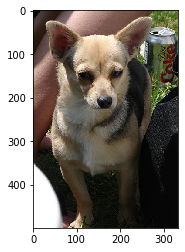

In [112]:
img = mpimg.imread(raw_data_path + "/n02085620_10074.jpg")
imgplot = plt.imshow(img)
plt.show()